# BFCL Error Analysis

This notebook loads outputs from `analyze_errors.py` and generates summary tables and plots for RQ2.

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

outdir = Path('analysis_out')
error_path = outdir / 'error_rows.parquet'
paired_path = outdir / 'paired_outcomes.parquet'

if error_path.exists():
    error_rows = pd.read_parquet(error_path)
else:
    error_rows = pd.read_csv(outdir / 'error_rows.csv')

if paired_path.exists():
    paired = pd.read_parquet(paired_path)
else:
    paired = pd.read_csv(outdir / 'paired_outcomes.csv')

error_rows.head()

,condition,model_name,category,id,valid,error_type,error_text,macro_bucket,tool_match,arg_overlap,near_miss_tool_correct_schema_wrong,prompt,model_result_decoded,possible_answer,filepath
0,OO,azure-gpt-4o-FC,web_search_base,web_search_base_2,False,agentic:answer_not_found,None of the expected answers were found in the...,other,False,None,False,"[[{""role"": ""system"", ""content"": ""For your fina...",None,"[""Dong-Sup Yoon"", ""Yoo Dong-Sup"", ""Yoon Dong-S...",score_desc_original_name_original\azure-gpt-4o...
1,OO,azure-gpt-4o-FC,web_search_base,web_search_base_3,False,agentic:inference_error,Error during inference phase. Model did not ou...,execution_runtime,False,None,False,"{""id"": ""web_search_base_3"", ""question"": [[{""ro...",None,"[""1871""]",score_desc_original_name_original\azure-gpt-4o...
2,OO,azure-gpt-4o-FC,web_search_base,web_search_base_5,False,agentic:answer_not_found,None of the expected answers were found in the...,other,False,None,False,"[[{""role"": ""system"", ""content"": ""For your fina...",None,"[""70""]",score_desc_original_name_original\azure-gpt-4o...
3,OO,azure-gpt-4o-FC,web_search_base,web_search_base_10,False,agentic:answer_not_found,None of the expected answers were found in the...,other,False,None,False,"[[{""role"": ""system"", ""content"": ""For your fina...",None,"[""27""]",score_desc_original_name_original\azure-gpt-4o...
4,OO,azure-gpt-4o-FC,web_search_base,web_search_base_11,False,agentic:answer_not_found,None of the expected answers were found in the...,other,False,None,False,"[[{""role"": ""system"", ""content"": ""For your fina...",None,"[""51""]",score_desc_original_name_original\azure-gpt-4o...


In [2]:
# Filter to models of interest (edit as needed)
models_of_interest = ['gpt-4o', 'gpt-5.1']
mask = error_rows['model_name'].str.contains('|'.join(models_of_interest), case=False, na=False)
error_rows_focus = error_rows[mask].copy()

error_rows_focus['condition'].value_counts()

condition
AA    3679
OO    3646
AO    1742
Name: count, dtype: int64

## Macro bucket shares by condition

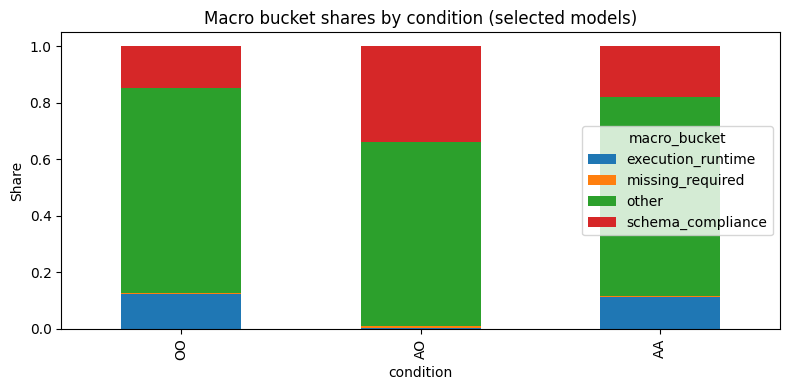

In [3]:
def plot_macro_bucket_shares(df, title):
    if df.empty:
        print('No data to plot')
        return
    counts = df.groupby(['condition', 'macro_bucket']).size().reset_index(name='count')
    total = counts.groupby('condition')['count'].transform('sum')
    counts['share'] = counts['count'] / total
    pivot = counts.pivot(index='condition', columns='macro_bucket', values='share').fillna(0)
    pivot = pivot.reindex(['OO','OA','AO','AA']).dropna(how='all')
    pivot.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(title)
    plt.ylabel('Share')
    plt.tight_layout()

plot_macro_bucket_shares(error_rows_focus, 'Macro bucket shares by condition (selected models)')

## Top error_type delta (OO to AA)

,OO,AA,delta
error_type,,,
ast_decoder:decoder_failed,142,291,149
value_error:string,401,435,34
parallel_function_checker_no_order:cannot_find_match,111,130,19
multi_turn:empty_turn_model_response,177,193,16
multi_turn:inference_error,302,312,10
multiple_function_checker:wrong_count,48,50,2
value_error:dict_value,6,8,2
relevance_error:decoder_failed,7,8,1
value_error:list/tuple,19,20,1


C:\Users\b-glanaro\AppData\Local\Temp\ipykernel_4916\262043966.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


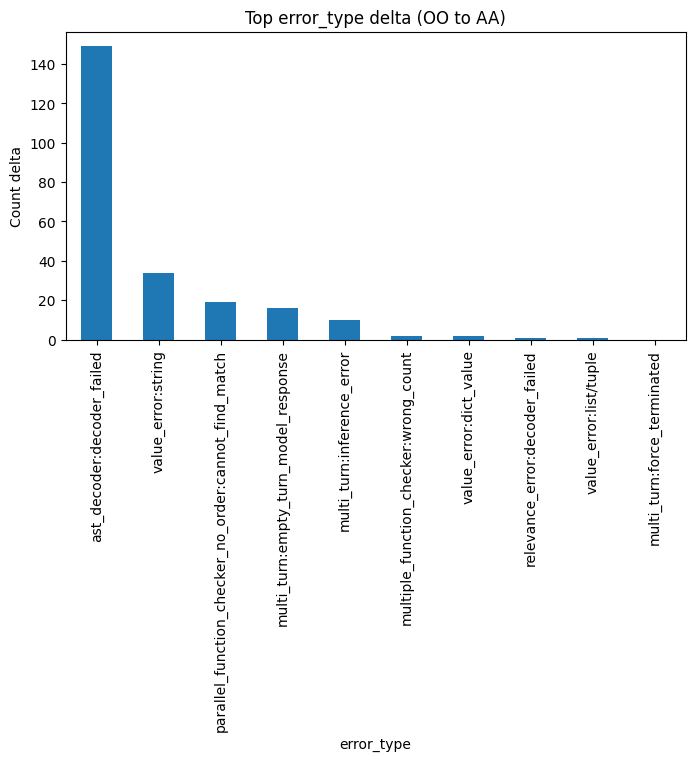

In [4]:
def top_error_type_delta(df, top_n=10):
    oo = df[df['condition'] == 'OO']['error_type'].value_counts()
    aa = df[df['condition'] == 'AA']['error_type'].value_counts()
    delta = pd.concat([oo, aa], axis=1).fillna(0)
    delta.columns = ['OO', 'AA']
    delta['delta'] = delta['AA'] - delta['OO']
    return delta.sort_values('delta', ascending=False).head(top_n)

if not error_rows_focus.empty:
    delta = top_error_type_delta(error_rows_focus)
    display(delta)
    delta['delta'].plot(kind='bar', figsize=(8,4))
    plt.title('Top error_type delta (OO to AA)')
    plt.ylabel('Count delta')
    plt.tight_layout()

## 16-way pattern distribution by category

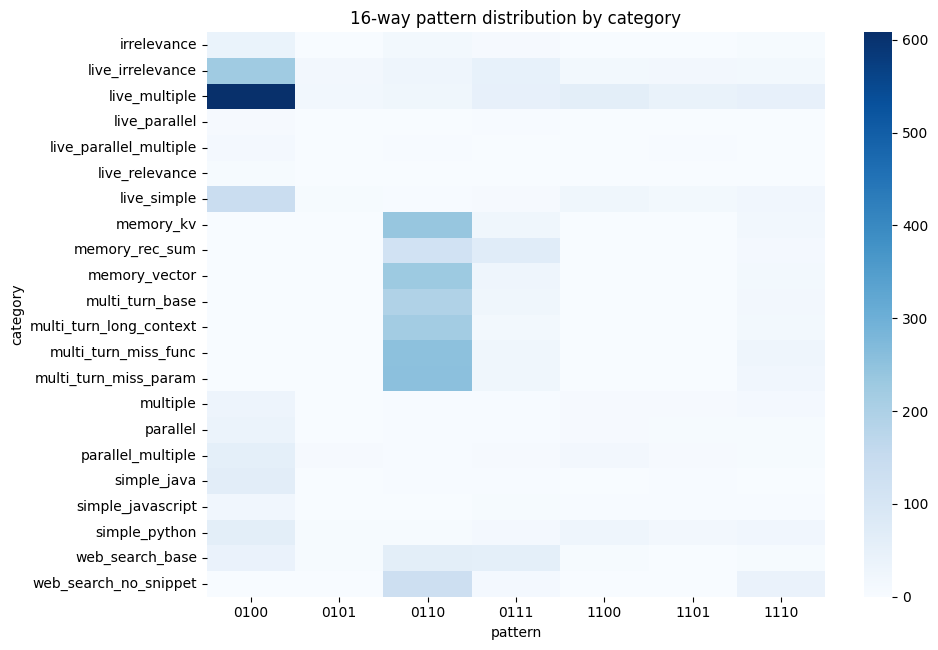

In [5]:
def pattern_heatmap(paired_df, title):
    if paired_df.empty or 'pattern' not in paired_df.columns:
        print('No pattern data')
        return
    table = paired_df.groupby(['category', 'pattern']).size().reset_index(name='count')
    pivot = table.pivot(index='category', columns='pattern', values='count').fillna(0)
    plt.figure(figsize=(10, max(4, len(pivot) * 0.3)))
    sns.heatmap(pivot, cmap='Blues', cbar=True)
    plt.title(title)
    plt.tight_layout()

pattern_heatmap(paired, '16-way pattern distribution by category')

## Transition counts by category

In [10]:
def transition_counts(paired_df):
    cols = [c for c in paired_df.columns if c.startswith('fixed_by_') or c.startswith('broken_by_')]
    if not cols:
        print('No transition columns')
        return
    table = paired_df.groupby('category')[cols].sum().reset_index()
    display(table.head(100))

transition_counts(paired)

,category,fixed_by_OA,broken_by_OA,fixed_by_AO,broken_by_AO,fixed_by_AA,broken_by_AA
0,irrelevance,63,0,24,2,9,7
1,live_irrelevance,320,0,78,32,67,31
2,live_multiple,703,0,76,108,70,115
3,live_parallel,13,0,4,0,3,0
4,live_parallel_multiple,16,0,3,4,0,2
5,live_relevance,7,0,2,2,1,2
6,live_simple,161,0,12,41,15,49
7,memory_kv,263,0,263,0,25,20
8,memory_rec_sum,188,0,188,0,70,13
9,memory_vector,258,0,258,0,30,15


## Example gallery: fixed and broken by AA

In [7]:
def example_gallery(error_rows_df, paired_df, n=5):
    if 'fixed_by_AA' not in paired_df.columns or 'broken_by_AA' not in paired_df.columns:
        print('AA transitions not available')
        return
    fixed_ids = paired_df[paired_df['fixed_by_AA']].head(n)[['model_name','category','id']]
    broken_ids = paired_df[paired_df['broken_by_AA']].head(n)[['model_name','category','id']]

    def extract_examples(subset, label):
        examples = error_rows_df.merge(subset, on=['model_name','category','id'], how='inner')
        cols = ['id','category','error_type','error_text','prompt']
        for col in cols:
            if col not in examples.columns:
                examples[col] = None
        examples = examples[cols].head(n).copy()
        if examples.empty:
            print(f"{label}: no matching rows")
            return
        examples['error_text'] = examples['error_text'].astype(str).str.slice(0, 160)
        examples['prompt'] = examples['prompt'].astype(str).str.slice(0, 200)
        print(f"{label}")
        display(examples)

    extract_examples(fixed_ids, 'Fixed by AA')
    extract_examples(broken_ids, 'Broken by AA')

example_gallery(error_rows_focus, paired, n=5)

Fixed by AA


,id,category,error_type,error_text,prompt
0,web_search_base_2,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
1,web_search_base_5,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
2,web_search_base_15,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
3,web_search_base_17,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
4,web_search_base_22,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."


Broken by AA


,id,category,error_type,error_text,prompt
0,web_search_base_0,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
1,web_search_base_38,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
2,web_search_base_48,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
3,web_search_base_52,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."
4,web_search_base_64,web_search_base,agentic:answer_not_found,None of the expected answers were found in the...,"[[{""role"": ""system"", ""content"": ""For your fina..."


## Optional: export HTML report

In [9]:
# Uncomment to export if nbconvert is available
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'html', 'error_analysis.ipynb', '--output', 'error_report.html'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'html', 'error_analysis.ipynb', '--output', 'error_report.html'], returncode=0)